In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [120]:
# Download Oxford 17 Category Flower Dataset
# !wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz -O 17flowers.tgz
# !tar -xvzf 17flowers.tgz

In [121]:
# Split the images in ./jpg into 17 folders
# !cd ./jpg && for i in {1..17}; do mkdir $i; done
# Move image_xxxx.jpg to folder (((xxxx-1)//80) + 1)
# !cd ./jpg && for i in {0001..1360}; do mv "image_$i.jpg" $(((i-1)/80 + 1)); done

In [122]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 17)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 3, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Define the training function
def train(model, device, train_loader, optimizer, epoch, loss_name):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.zeros(target.size(0), 17).scatter_(1, target.unsqueeze(1), 1)
        target_one_hot = target_one_hot.to(device)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = None
        # Try different loss functions for classification:'nll_loss', 'cross_entropy', 'smooth_l1_loss', 'soft_margin_loss'
        if loss_name == 'nll_loss':
            loss = F.nll_loss(output, target)
        elif loss_name == 'cross_entropy':
            loss = F.cross_entropy(output, target_one_hot)
        elif loss_name == 'smooth_l1_loss':
            loss = F.smooth_l1_loss(output, target_one_hot)
        elif loss_name == 'soft_margin_loss':
            loss = F.soft_margin_loss(output, target_one_hot)
        else:
            loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function
def validate(model, device, val_loader, loss_name):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            target_one_hot = torch.zeros(target.size(0), 17).scatter_(1, target.unsqueeze(1), 1)
            target_one_hot = target_one_hot.to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            if loss_name == 'nll_loss':
                val_loss += F.nll_loss(output, target, reduction='sum').item()
            elif loss_name == 'cross_entropy':
                val_loss += F.cross_entropy(output, target_one_hot, reduction='sum').item()
            elif loss_name == 'smooth_l1_loss':
                val_loss += F.smooth_l1_loss(output, target_one_hot, reduction='sum').item()
            elif loss_name == 'soft_margin_loss':
                val_loss += F.soft_margin_loss(output, target_one_hot, reduction='sum').item()
            else:
                val_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return val_loss

# Define the testing function
def test(model, device, test_loader, loss_name):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target_one_hot = torch.zeros(target.size(0), 17).scatter_(1, target.unsqueeze(1), 1)
            target_one_hot = target_one_hot.to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            if loss_name == 'nll_loss':
                test_loss += F.nll_loss(output, target, reduction='sum').item()
            elif loss_name == 'cross_entropy':
                test_loss += F.cross_entropy(output, target_one_hot, reduction='sum').item()
            elif loss_name == 'smooth_l1_loss':
                test_loss += F.smooth_l1_loss(output, target_one_hot, reduction='sum').item()
            elif loss_name == 'soft_margin_loss':
                test_loss += F.soft_margin_loss(output, target_one_hot, reduction='sum').item()
            else:
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)


In [123]:
# Define the data preparation function
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the dataset
Dataset = torchvision.datasets.ImageFolder(root='./jpg', transform=data_transform)
train_size = int(0.8 * len(Dataset))
val_size = int(0.1 * len(Dataset))
test_size = len(Dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(Dataset, [train_size, val_size, test_size])

# Load the dataset into dataloader with target size (batch_size, 17)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [124]:
# Define the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [125]:
# Train with different loss functions
accuracies = []
all_train_losses = []
all_val_losses = []
loss_names = ['nll_loss', 'cross_entropy', 'smooth_l1_loss', 'soft_margin_loss']
for loss_name in loss_names:
    # Define the model
    model = AlexNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    val_losses = []
    for epoch in range(1, 50 + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, loss_name)
        val_loss = validate(model, device, val_loader, loss_name)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    test_loss, accuracy = test(model, device, test_loader, loss_name)
    accuracies.append(accuracy/100)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

Train Epoch: 1 [0/1088 (0%)]	Loss: 2.831500
Train Epoch: 1 [320/1088 (29%)]	Loss: 2.938688
Train Epoch: 1 [640/1088 (59%)]	Loss: 2.825123
Train Epoch: 1 [960/1088 (88%)]	Loss: 2.684668
Validation set: Average loss: 2.6291, Accuracy: 10/136 (7%)
Train Epoch: 2 [0/1088 (0%)]	Loss: 2.641705
Train Epoch: 2 [320/1088 (29%)]	Loss: 2.590754
Train Epoch: 2 [640/1088 (59%)]	Loss: 2.430524
Train Epoch: 2 [960/1088 (88%)]	Loss: 2.514006
Validation set: Average loss: 2.3462, Accuracy: 22/136 (16%)
Train Epoch: 3 [0/1088 (0%)]	Loss: 2.208068
Train Epoch: 3 [320/1088 (29%)]	Loss: 2.416075
Train Epoch: 3 [640/1088 (59%)]	Loss: 2.264484
Train Epoch: 3 [960/1088 (88%)]	Loss: 2.283740
Validation set: Average loss: 2.3083, Accuracy: 20/136 (15%)
Train Epoch: 4 [0/1088 (0%)]	Loss: 2.172097
Train Epoch: 4 [320/1088 (29%)]	Loss: 2.077145
Train Epoch: 4 [640/1088 (59%)]	Loss: 2.252016
Train Epoch: 4 [960/1088 (88%)]	Loss: 2.090035
Validation set: Average loss: 2.0086, Accuracy: 37/136 (27%)
Train Epoch: 5 [0

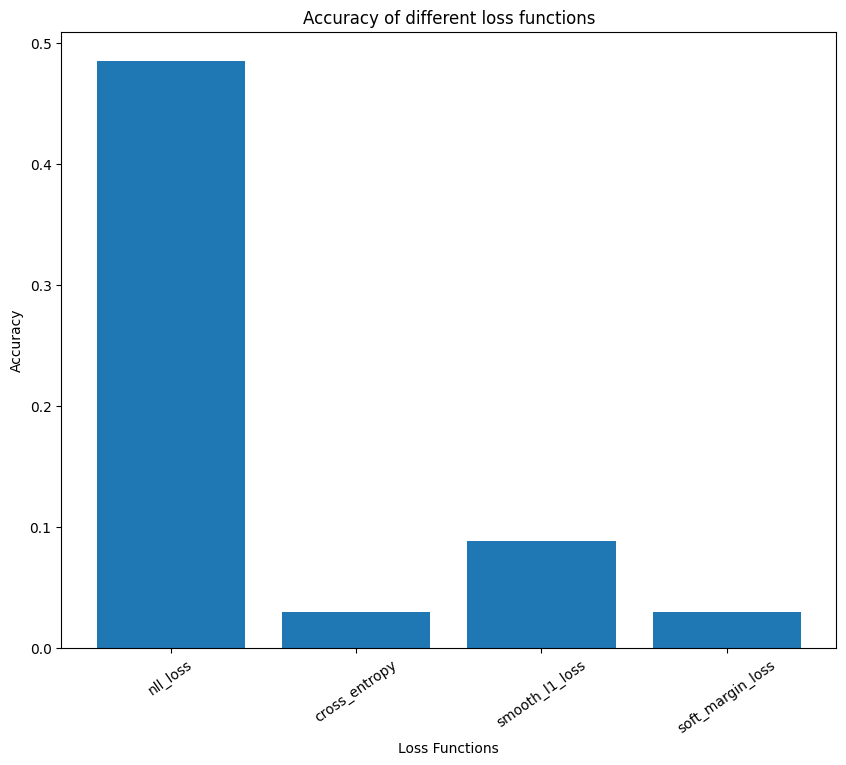

In [126]:
# Plot the accuracies as a bar chart
plt.figure(figsize = (10, 8))
plt.bar(loss_names, accuracies)
plt.xlabel('Loss Functions')
plt.ylabel('Accuracy')
plt.xticks(rotation = 35)
plt.title('Accuracy of different loss functions')
plt.show()

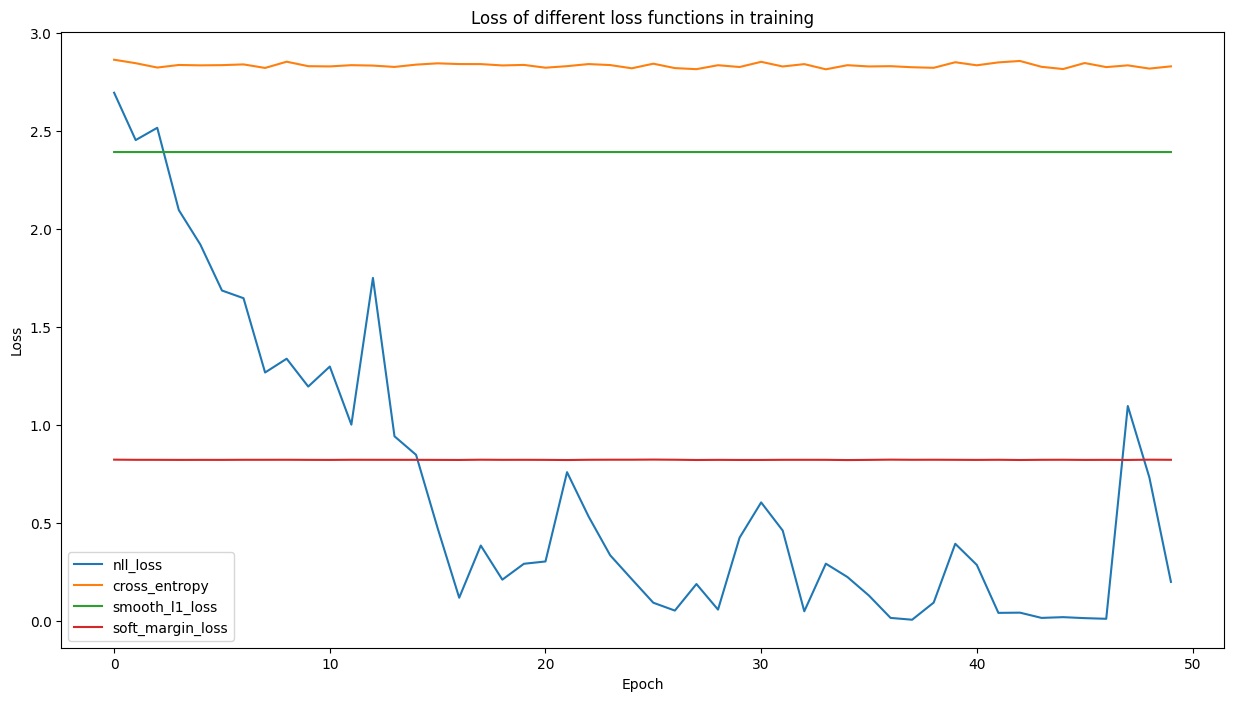

In [127]:
# Plot the train losses as lines of each loss function
plt.figure(figsize=(15, 8))
for i in range(len(loss_names)):
    plt.plot(all_train_losses[i], label = loss_names[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of different loss functions in training')
plt.legend()
plt.show()


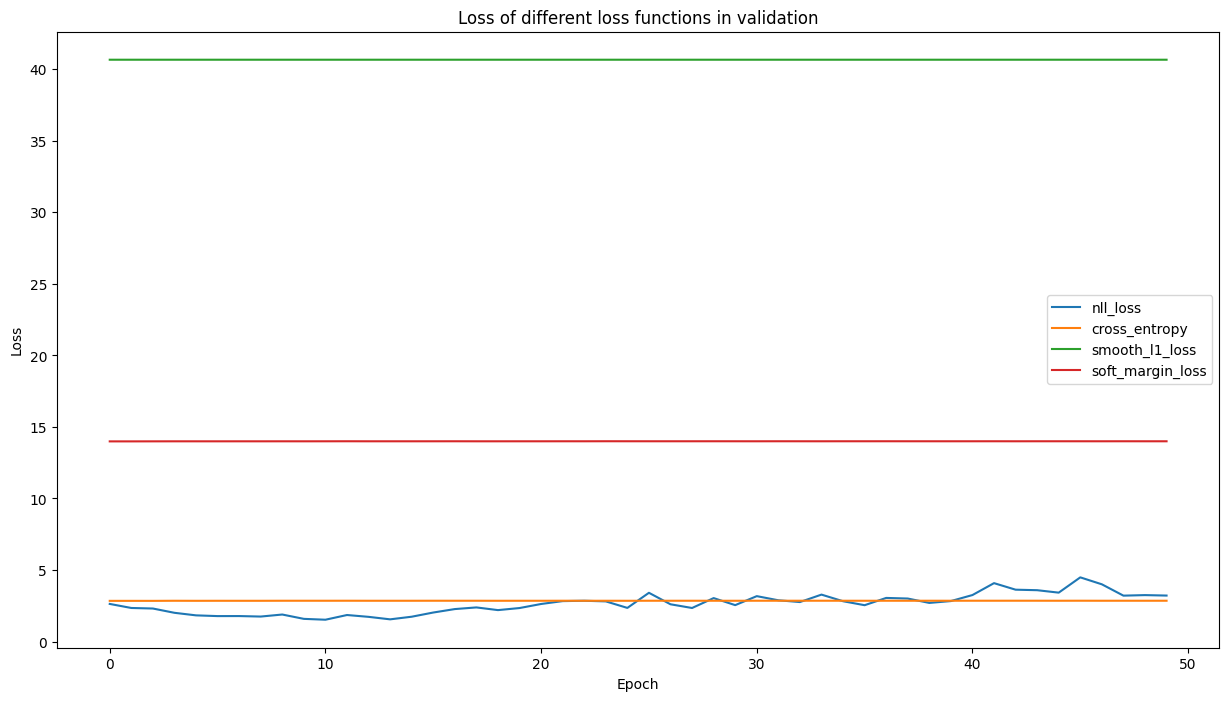

In [128]:
# Plot the validation losses as lines of each loss function
plt.figure(figsize=(15, 8))
for i in range(len(loss_names)):
    plt.plot(all_val_losses[i], label = loss_names[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of different loss functions in validation')
plt.legend()
plt.show()

In [140]:
# Output the data in AlexLoss.csv
df_acc = pd.DataFrame({'Loss Function' : loss_names, 'Accuracy' : accuracies, 'Train Loss' : [all_train_losses[i][-1] for i in range(len(loss_names))], 'Validation Loss' : [all_val_losses[i][-1] for i in range(len(loss_names))]})
df_acc.to_csv('AlexLoss_acc.csv', encoding='utf-8', index=False)
df_loss_train = pd.DataFrame({'nll_loss' : all_train_losses[0], 'cross_entropy' : all_train_losses[1],  'smooth_l1_loss' : all_train_losses[2],'soft_margin_loss' : all_train_losses[3]})
df_loss_train.to_csv('AlexLoss_train.csv', encoding='utf-8', index=False)
df_loss_val = pd.DataFrame({'nll_loss' : all_val_losses[0],  'cross_entropy' : all_val_losses[1],  'smooth_l1_loss' : all_val_losses[2],'soft_margin_loss' : all_val_losses[3]})
df_loss_val.to_csv('AlexLoss_val.csv', encoding='utf-8', index=False)